In [1]:
import os
import sys

python_working_dir = !pwd
package_path = '/'.join(python_working_dir[0].split('/')[:-1])
print(package_path)

sys.path.append(package_path)

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fraud_prevention.features import cc_transaction_features

/Users/luis.sanchez/conekta/project


In [2]:
data = cc_transaction_features.get()

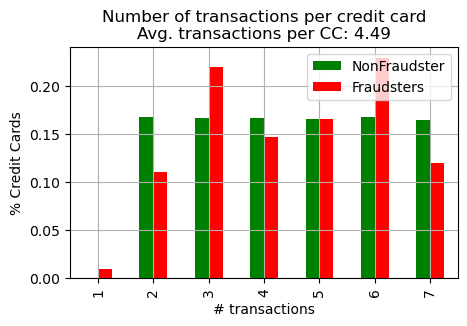

In [3]:
cc_avg_transactions = data.groupby(
    'credit_card_number'
).size().mean()

class_and_color = zip([0, 1], ['green', 'red'])
data_plot = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot[cls_name] = (
        data[
            data['Class'] == cls
        ].groupby('credit_card_number').size()
    ).value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data_plot = pd.DataFrame(data_plot)
(data_plot / data_plot.sum()).plot(
    kind='bar',
    ax=ax,
    color=['green', 'red'])
ax.set_title(
    'Number of transactions per credit card\n'
    f'Avg. transactions per CC: {round(cc_avg_transactions, 2)}'
)
ax.set_ylabel('% Credit Cards')
ax.set_xlabel('# transactions');

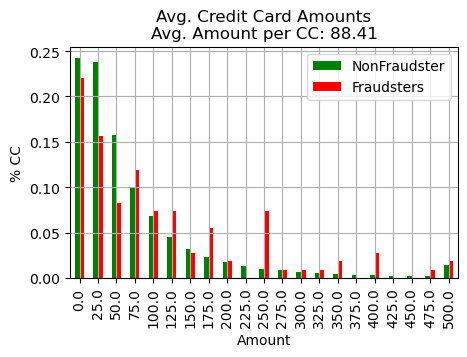

In [4]:
amount_means = data.groupby(
    'credit_card_number'
)['Amount'].mean().mean()

class_and_color = zip([0, 1], ['green', 'red'])
amounts = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ].groupby(
        'credit_card_number'
    )['Amount'].mean()
    data_plot.name = f'{cls_name} Amount Avg'

    amounts[cls_name] = data_plot.apply(
        lambda x: x - (x % 25)
    ).clip(0, 500).value_counts()

amounts = pd.DataFrame(amounts)
amounts = amounts / amounts.sum()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
amounts.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])
ax.set_ylabel('% CC')
ax.set_xlabel('Amount')
ax.set_title(
    'Avg. Credit Card Amounts\n'
    f'Avg. Amount per CC: {round(amount_means, 2)}');

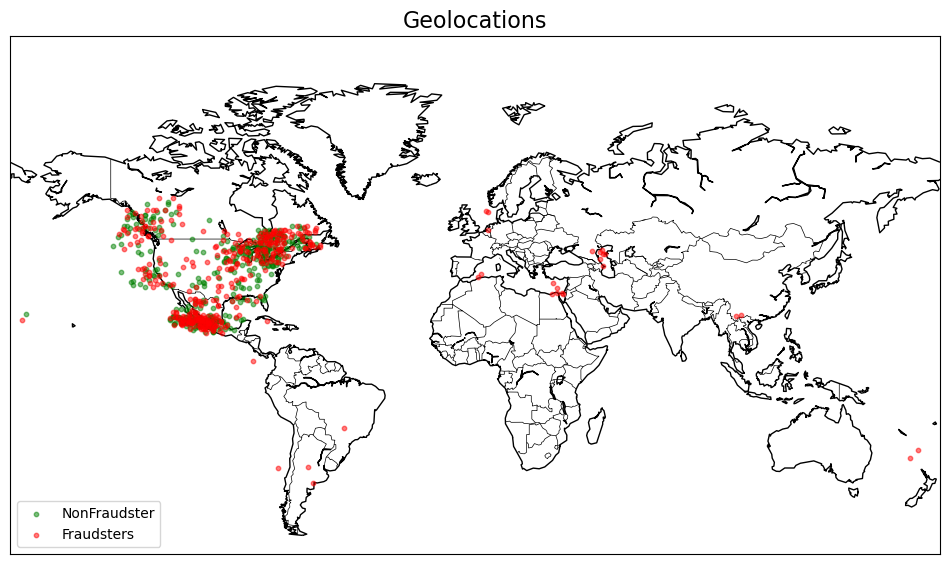

In [5]:
import random

# Create a new figure
plt.figure(figsize=(12, 8))

# Create a basemap instance for the whole world
m = Basemap(
    projection='mill', 
    llcrnrlat=-60, 
    urcrnrlat=90,
    llcrnrlon=-180, 
    urcrnrlon=180, 
    resolution='c')

# Draw coastlines and country boundaries
m.drawcoastlines()
m.drawcountries()

for cls, data_sample in data.groupby('Class'):
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    if len(data_sample) > 400:
        data_sample = data_sample.sample(400)

    lats = data_sample['latitude'].astype(float).apply(
        lambda x: x * (
            1 + (.01 * random.choice(list(range(0, 15))))
        )
    ).astype(float).tolist()

    lons = data_sample['longitude'].astype(float).apply(
        lambda x: x * (
            1 + (.01 * random.choice(list(range(0, 15))))
        )
    ).astype(float).tolist()
    
    x, y = m(lons, lats)
    data_sample['x'] = x
    data_sample['y'] = y
    
    if cls == 1:
        color = 'red'
        alpha = .5
    else:
        color = 'green'
        alpha = .5

    m.scatter(
        x, y, color=color, marker='o', s=10, zorder=5, label=cls_name, alpha=alpha)

# Add a title and legend
plt.title("Geolocations", fontsize=16)
plt.legend(loc='lower left')

# Show the plot
plt.show()

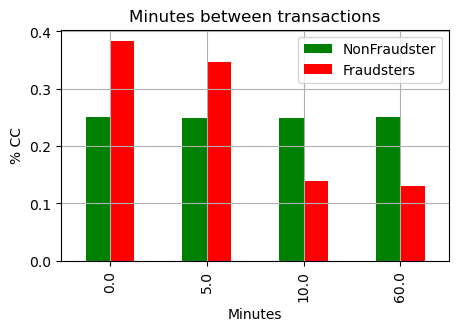

In [6]:
class_and_color = zip([0, 1], ['green', 'red'])
prev_time = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ]['time_prev_transaction'].apply(
        lambda x: x - (x % 5)
    ).value_counts()
    data_plot.name = f'{cls_name} Time prev. transaction'

    prev_time[cls_name] = data_plot

prev_times = pd.DataFrame(prev_time)
data_plot = (prev_times / prev_times.sum())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data_plot.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])
ax.set_ylabel('% CC')
ax.set_xlabel('Minutes')
ax.set_title(
    'Minutes between transactions');

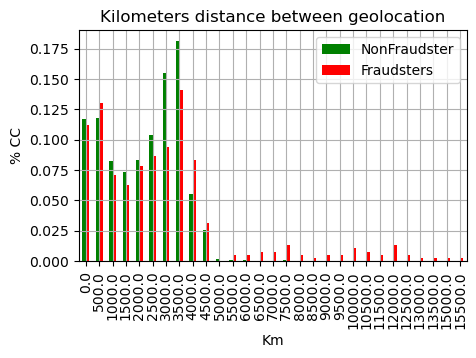

In [7]:
class_and_color = zip([0, 1], ['green', 'red'])
prev_time = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ]['km_dist_prev_transaction'].apply(
        lambda x: x - (x % 500)
    ).value_counts()
    data_plot.name = f'{cls_name} Time prev. transaction'

    prev_time[cls_name] = data_plot

prev_times = pd.DataFrame(prev_time)
data_plot = (prev_times / prev_times.sum())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data_plot.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])

ax.set_ylabel('% CC')
ax.set_xlabel('Km')
ax.set_title(
    'Kilometers distance between geolocation');